In [ ]:
import numpy as np
from random import *


class Layer_Dense:

    #Initialisation d'une couche de réseau
    def __init__(self, d_inputs, n_neurons, n_inputs):
        self.d_inputs = d_inputs
        self.n_neurons = n_neurons
        self.n_inputs = n_inputs
        self.weights = np.empty((n_neurons, d_inputs))
        self.biases = np.empty((n_neurons, n_inputs))

    #Utilisation d'une couche
    def forward(self, inputs):
        self.output= np.dot(self.weights, inputs) + self.biases

    #Attribution aléatoire de paramètres, globalement pour initialiser un réseau si on ne dispose pas déjà d'un modèle
    def attrib_r(self, fact=1):
      self.weights = 0.10 * np.random.randn(self.n_neurons, self.d_inputs)* fact
      self.biases = np.tile(0.1*fact * np.random.randn(1, self.n_neurons).reshape(-1, 1), (1, self.n_inputs))

    #Création d'une couche subissant des mutations aléatoires à partir d'une couche "modèle", fonction utilisée pour les apprentissages "heuristiques"
    # p : probabilité qu'un coefficient soit muté. cr : intervalle dans lequel est choisie la variation des paramètres mutés
    def mut(self, p, cr):

        Lay = Layer_Dense(self.d_inputs, self.n_neurons, self.n_inputs)

        Lay.weights = self.weights.copy()
        Lay.biases = self.biases.copy()

        n_weights = self.n_neurons*self.d_inputs
        num_w_mod = int(n_weights * p)

        if num_w_mod > 0:
            indices = np.unravel_index(np.random.choice(n_weights, num_w_mod, replace=False), (self.n_neurons, self.d_inputs))
            changes_w = np.random.uniform(-cr, cr, num_w_mod)
            Lay.weights[indices] += changes_w

        n_b = self.n_neurons
        num_b_mod = int(n_b*p)+ (1 if random() < 0.5 else 0)

        if num_b_mod > 0:
            indices_b = np.unravel_index(np.random.choice(n_b, num_b_mod, replace=False), (n_b, 1))
            changes_b = np.random.uniform(-cr, cr, num_b_mod)
            Lay.biases[indices_b] += changes_b
        
        return(Lay)
    
class NeuralN:
    #Initialisation d'un réseau, constitué d'une liste de couches
    def  __init__(self, l):
        self.l = l
        self.wl = []

    #Obtenir le résultat donné par le réseau à partir d'une entrée
    def process(self, input):
        output = input
        for layers in self.l:
            layers.forward(output)
            output = layers.output
        return output.T
    
    #Mutation aléatoire du réseau
    def mutNN(self, p, cr):
        return NeuralN([layers.mut(p, cr) for layers in self.l])
    
    #Attribution aléatoire des paramètres du réseau
    def attribNN_r(self, fact=1):
        for layers in self.l:
            layers.attrib_r(fact)
        
    #Pour manipuler plus facilement les poids
    def wl_update(self):
        self.wl= []
        for r in self.l:
            n , d = r.n_neurons, r.d_inputs
            for i in range(n):
                for k in range(d): #weights
                    self.wl.append(r.weights[i][k])
            for i in range(n): #biases
                self.wl.append(r.biases[i][0])



    #Permet de sauvegarder un réseau dans un fichier .txt afin de conserver des modèles           
    def save_to_file(self, filename, network_id):
        with open(filename, 'a') as f:  # 'a' pour ajouter sans écraser
            f.write(f'### Network ID: {network_id} ###\n')  # Indicateur d'identifiant du réseau
            for layer in self.l:
                # Sauvegarder les dimensions de la couche
                f.write(f'{layer.d_inputs},{layer.n_neurons},{layer.n_inputs}\n')

                # Sauvegarder les poids
                f.write('weights:\n')
                for row in layer.weights:
                    f.write(','.join(map(str, row)) + '\n')

                # Sauvegarder les biais
                f.write('biases:\n')
                for row in layer.biases:
                    f.write(','.join(map(str, row)) + '\n')
            
            f.write("### End of Network ###\n")  # Marqueur de fin du réseau

    # Recréer un réseau sauvegardé avec un identifiant donné
    def load_from_file(self, filename, network_id):
        self.l = []  # Réinitialiser les couches avant de charger
        with open(filename, 'r') as f:
            lines = f.readlines()
            i = 0
            found = False  # Pour détecter si le réseau a été trouvé

            while i < len(lines):
                # Rechercher le début du réseau avec l'ID donné
                if lines[i].strip() == f'### Network ID: {network_id} ###':
                    found = True
                    i += 1
                    while i < len(lines) and lines[i].strip() != "### End of Network ###":
                        # Charger les dimensions de la couche
                        d_inputs, n_neurons, n_inputs = map(int, lines[i].strip().split(','))
                        i += 1

                        layer = Layer_Dense(d_inputs, n_neurons, n_inputs)

                        # Charger les poids
                        if lines[i].strip() == 'weights:':
                            i += 1
                            weights = []
                            for _ in range(n_neurons):
                                weights.append(list(map(float, lines[i].strip().split(','))))
                                i += 1
                            layer.weights = np.array(weights)

                        # Charger les biais
                        if lines[i].strip() == 'biases:':
                            i += 1
                            biases = []
                            for _ in range(n_neurons):
                                biases.append(list(map(float, lines[i].strip().split(','))))
                                i += 1
                            layer.biases = np.array(biases)

                        # Ajouter la couche chargée à la liste des couches du réseau
                        self.l.append(layer)
                
                if found and lines[i].strip() == "### End of Network ###":
                    break  # Fin de chargement du réseau
                i += 1

            if not found:
                print(f"Network ID '{network_id}' not found.")
    
class Opti:

    #Les "Opti" sont un quadruplet regroupant un algorithme d'optimisation, un réseau à entrainer, ainsi que la fonction de perte et son gradient, sur lesquels on souhaite entrainer le réseau
    #Il est intéressant de créer cette structure en plus de celle des "Algos" (à venir) qui est elle orientée sur l'aspect purement théorique / algorithmique. Les "Opti" sont une application pratique des "Algos".
    def __init__(self, fonc, NN, grad, loss):
        self.f = fonc
        self.NN = NN
        self.grad = grad
        self.gl = []
        self.loss = loss
        t = 0
        for r in NN.l:
            t += (r.n_neurons*(r.d_inputs+1))
        self.v = (np.zeros((t, fonc.vl)) if self.f.vlist == [] else [self.f.vlist for i in range(t)])

    
    def gr_update(self):
        self.gl = self.grad(self.NN.wl)

    #Modification des poids du réseau tel que l'algorithme d'optimisation l'indique.
    def update(self):
        self.gr_update()
        j = 0
        for r in self.NN.l:
            n , d = r.n_neurons, r.d_inputs
            for i in range(n):
                for k in range(d): #weights
                    (r.weights[i][k], self.v[(i*d)+k+j]) = self.f.mod(r.weights[i][k], self.gl[(i*d)+k+j], self.v[(i*d)+k+j])
            j+=n*d
            for i in range(n): #biases
                (r.biases[i], self.v[i+j]) = self.f.mod(r.biases[i][0], self.gl[i+j], self.v[i+j])
            j += n

    #Processus de modification des poids de nombreuses fois à la suite
    #train renvoie l'évolution de la perte et des poids, train2 renvoie uniquement la perte
    def train(self, nb_epoch):
        losslst, poidslst = [], []
        for epoch in range(nb_epoch):
            self.NN.wl_update()
            losslst.append(self.loss(self.NN.wl))
            poidslst.append(self.NN.wl)
            self.update()
        return (losslst, poidslst)
    
    def train2(self, nb_epoch):
        losslst = []
        for epoch in range(nb_epoch):
            self.NN.wl_update()
            losslst.append(self.loss(self.NN.wl))
            self.update()
        return losslst



class Algos:
    #Un algorithme d'optimisation "Algo" est constitué d'un algorithme nécessitant une liste d'hyperparamètres ainsi que de variables pour fonctionner, d'où la nature de la structure.
    def __init__(self, algo, param, vlen, name="", vlist=[]):
        self.a = algo
        self.p = param
        self.vl = vlen
        self.name = name
        self.vlist = vlist

    def mod(self, w, g, vlst):
        return self.a(w, g, self.p, vlst)
    
from matplotlib import pyplot as p

class Visu:
    #Objet utilisant les classes précédentes pour, à partir d'une liste d'"Algos" et d'un format de réseau, effectuer tout le processus d'entraînement puis afficher les résulats.
    def __init__(self, NNi, fctgr, perte, l_algos, n, start):
        self.l_algos = l_algos
        self.n = n
        if start == []:
            NNi.attribNN_r()
        else:
            j = 0
            for r in NNi.l:
                n,d = r.n_neurons, r.d_inputs
                for i in range(n):
                    for k in range(d): #weights
                        r.weights[i][k] = start[(i*d)+k+j]
                j+=n*d
                for i in range(n): #biases
                    r.biases[i] = start[i+j]
                j+=n

        self.NNi = NNi
        self.fct = fctgr
        self.perte = perte

    #Affiche les résultats via une courbe 2d, évolution de la perte en fonction du nombre d'itérations.
    def plt(self, logscale=True, return_weights=False):
        p.figure(figsize=(17,7))
        colors = ['b', 'c', 'm', 'g', 'y', 'r']
        if return_weights:
            for i, algos in enumerate(self.l_algos):
                opt = Opti(algos, self.NNi.mutNN(0,0), self.fct, self.perte)
                res = opt.train(self.n)
                p.plot([a for a in range(self.n)], res[0], (colors[i] if i < 7 else 'k'), label=algos.name)
                print(res[1])
        else:
            for i, algos in enumerate(self.l_algos):
                opt = Opti(algos, self.NNi.mutNN(0,0), self.fct, self.perte)
                p.plot([a for a in range(self.n)], opt.train2(self.n), (colors[i] if i < 7 else 'k'), label=algos.name)
        p.legend(loc='upper right')
                
        if logscale:
            p.yscale('log')

    #Ouvre une interface 3d permettant de visualiser l'évolution des poids sur une fonction de perte à 2 entrées x,y.
    #Utile pour comprendre le comportement des algorithmes d'optimisation et développer des solutions.
    def visu(self, coosx, coosy, dt, ballscale=0.5, logscale=False):#Pour de la dimension 2
        from mayavi import mlab
        import time as t
        coos, losses, balls = [], [], []
        c = [(0.1, 0.6, 1), (1, 0.6, 0.1), (0.3, 0.6, 0.3), (1, 1, 1)]
        x = np.linspace(coosx[0],coosx[1], 200)
        y = np.linspace(coosy[0],coosy[1], 200)
        X1, Y1 = np.meshgrid(x, y)
        Z1 = (self.perte([X1, Y1]) if not logscale else np.log(self.perte([X1, Y1])))
        mlab.figure(size=(800, 600), bgcolor=(0.4, 0.4, 0.6))
        mlab.mesh(X1, Y1, Z1, colormap='CMRmap')
        for i, algos in enumerate(self.l_algos):
            o = Opti(algos, self.NNi.mutNN(0,0), self.fct, self.perte)
            res = o.train(self.n)
            coos.append(res[1])
            losses.append((np.log(res[0]) if logscale else res[0]))
            balls.append(mlab.points3d(coos[i][0][0], coos[i][0][1], losses[i][0], scale_factor=ballscale, color=c[i]))

        def update_ball():
            i = 0
            while i < self.n-1:
                for a in range(len(balls)):
                    co = coos[a][i]
                    balls[a].mlab_source.set(x=co[0], y=co[1], z=losses[a][i])
                t.sleep(dt)    
                yield
                i+=1

        anim = update_ball()
        mlab.show(stop=True)

        while True:
            try:
                next(anim)
            except StopIteration:
                break
            mlab.process_ui_events()
        mlab.show()

In [ ]:
path2 = r"D:\Prépa\save_NNs2.txt"

Implémentation de quelques optimizers

In [3]:
def Sgd(w, g, p, vl):
    return (w - p[0]*g, vl)

def SgdM(w, g, p, vl):
    momentum, lr, B = vl[0], p[0], p[1]
    momentum = B*momentum + (1-B)*g
    return (w-lr*momentum, [momentum])

SGD_Trad = Algos(Sgd, [0.03], 0, name="SGD_Trad")
SGDM_Trad = Algos(SgdM, [0.03, 0.9], 1,name="SGDM_Trad")
SGD_Slow = Algos(Sgd, [0.001], 0, name="SDG_Slow")
SGDM_Slow= Algos(SgdM, [0.003 , 0.95], 1, name="SGDM_Slow")

def Adam(w, g, p, vl):
    lr, b1, b2, eps = p[0], p[1], p[2], p[3]
    m1, m2, v, v2 = vl[1], vl[2], vl[3], vl[4]
    m1 = b1*m1 +(1-b1)*g
    m2 = m1/(1-b1**(vl[0]+1))
    v = b2*v+(1-b2)*(g**2)
    v2 = v/(1-b2**(vl[0]+1))
    return (w - lr*m2*(1/(eps+np.sqrt(v2))), [vl[0]+1, m1, m2, v, v2])

ADAM_Trad = Algos(Adam, [0.03, 0.9, 0.999, 10**(-8)], 5, name="Adam_Trad")

Implémentation des fonctions de test ainsi que de leurs gradients

In [4]:
import math as m
def rosenbrock(lst):
    x, y = lst[0], lst[1]
    return((1-x)**2 + 100*(y-(x)**2)**2)
def grosenbrock(lst):
    x, y = lst[0], lst[1]
    return [2*(x-1) +400*x*((x)**2 -y), 200*(y-(x)**2)]

def rastrigin(lst):
    return (10*len(lst) + np.sum([(lst[i]**2 - 10*np.cos(2*m.pi*lst[i])) for i in range(len(lst))], axis = 0))
def grastrigin(lst):
    return [(2*lst[i]+ 20*m.pi*np.sin(2*m.pi*lst[i])) for i in range(len(lst))]

def himmelblau(lst):
    x, y = lst[0], lst[1]
    return ((x**2 +y-11)**2 + (x+ y**2 - 7)**2)
def grhimmelblau(lst):
    x, y = lst[0], lst[1]
    return [4*x*(x**2 + y -11) + 2*(x+ y**2 - 7), 2*(x**2 + y -11)+4*y*(x+ y**2 -7)]

Implémentation de mon optimizer. Plusieurs versions sont codées.

In [5]:
import math as m
import statistics as s

def softmax_abs(lst):
    l1 = list(map(abs, lst))
    somme = sum(l1)
    l2 = [l/(somme + (10**(-20))) for l in l1]
    l = list(map(m.exp, l2))
    s = sum(l)
    return [((10**(-9))+(l[i]/s))*(1 if lst[i] > 0 else -1) for i in range(len(lst))]

def softmax_abs2(lst):
    l1 = list(map(abs, lst))
    somme = sum(l1)
    l2 = [l/(somme + (10**(-20))) for l in l1]
    l = list(map(m.exp, l2))
    s = sum(l)
    return [((10**(-9))+(l[i]/s))*(1 if lst[i] > 0 else -1) for i in range(len(lst))], somme


def o1_a(w, g, p, vl):
    gl, NN, iter = vl[1], vl[2], vl[3]
    gl.pop(0)
    gl.append(g)
    if iter == 0:
        gl = [g]*5
    alpha = abs(NN.process(np.array([softmax_abs(gl)]).T)[0][0])

    b, mom = p[0], vl[0]
    mom = (1-b)*mom +b*g
    return(w-alpha*mom, [mom, gl, NN, iter+1])

def o1_2_a(w, g, p, vl):
    gl, NN, iter = vl[1], vl[2], vl[3]
    gl.pop(0)
    gl.append(g)
    if iter == 0:
        gl = [g]*5

    softmax, somme = softmax_abs2(gl)
    v  = s.variance(gl)/somme
    softmax.append(v)
    
    out = abs(NN.process(np.array([softmax]).T)[0][0])
    alpha = m.exp(-out*100)
    b, mom = p[0], vl[0]
    mom = (1-b)*mom +b*g
    return(w-alpha*mom, [mom, gl, NN, iter+1])

def o1_3_a(w, g, p, vl):
    gl, NN, iter = vl[1], vl[2], vl[3]
    gl.pop(0)
    gl.append(g)
    if iter == 0:
        gl = [g]+[0]*4

    softmax, somme = softmax_abs2(gl)
    v  = s.variance(gl)/somme
    softmax.append(v)
    
    out = abs(NN.process(np.array([softmax]).T)[0][0])
    alpha = m.exp(-out*100)
    b, mom = p[0], vl[0]
    mom = (1-b)*mom +b*g
    return(w-alpha*mom, [mom, gl, NN, iter+1])

Cellule d'entrainement de la dernière version de l'algorithme

C:\Users\paulm\AppData\Local\Temp\ipykernel_2924\479230742.py:4: RuntimeWarning: overflow encountered in scalar power
  return((1-x)**2 + 100*(y-(x)**2)**2)
c:\Users\paulm\AppData\Local\Programs\Python\Python310\lib\statistics.py:723: RuntimeWarning: overflow encountered in scalar power
  T, total, count = _sum((x-c)**2 for x in data)


Génération 0 done, bestloss = 80976559.13897473


C:\Users\paulm\AppData\Local\Temp\ipykernel_2924\479230742.py:7: RuntimeWarning: overflow encountered in scalar multiply
  return [2*(x-1) +400*x*((x)**2 -y), 200*(y-(x)**2)]
C:\Users\paulm\AppData\Local\Temp\ipykernel_2924\2185989792.py:15: RuntimeWarning: invalid value encountered in scalar divide
  l2 = [l/(somme + (10**(-20))) for l in l1]
c:\Users\paulm\AppData\Local\Programs\Python\Python310\lib\statistics.py:723: RuntimeWarning: invalid value encountered in scalar subtract
  T, total, count = _sum((x-c)**2 for x in data)
c:\Users\paulm\AppData\Local\Programs\Python\Python310\lib\statistics.py:726: RuntimeWarning: invalid value encountered in scalar subtract
  U, total2, count2 = _sum((x - c) for x in data)
C:\Users\paulm\AppData\Local\Temp\ipykernel_2924\479230742.py:16: RuntimeWarning: overflow encountered in scalar power
  return ((x**2 +y-11)**2 + (x+ y**2 - 7)**2)
C:\Users\paulm\AppData\Local\Temp\ipykernel_2924\479230742.py:19: RuntimeWarning: overflow encountered in scalar

Génération 1 done, bestloss = 39734472.78894789
Génération 2 done, bestloss = 39734472.78894789
Génération 3 done, bestloss = 37668892.22690605
Génération 4 done, bestloss = 37668892.22690605
Génération 5 done, bestloss = 37668892.22690605
Génération 6 done, bestloss = 21130956.376096737
Génération 7 done, bestloss = 21130956.376096737
Génération 8 done, bestloss = 21130956.376096737
Génération 9 done, bestloss = 13911643.904253071
Génération 10 done, bestloss = 13911643.904253071
Génération 11 done, bestloss = 13911643.904253071
Génération 12 done, bestloss = 11613005.05324395
Génération 13 done, bestloss = 11613005.05324395
Génération 14 done, bestloss = 11613005.05324395
Génération 15 done, bestloss = 11112648.228184557
Génération 16 done, bestloss = 11112648.228184557
Génération 17 done, bestloss = 11112648.228184557
Génération 18 done, bestloss = 8826841.587827269
Génération 19 done, bestloss = 8826841.587827269
[80976559.13897473, 39734472.78894789, 39734472.78894789, 37668892.22

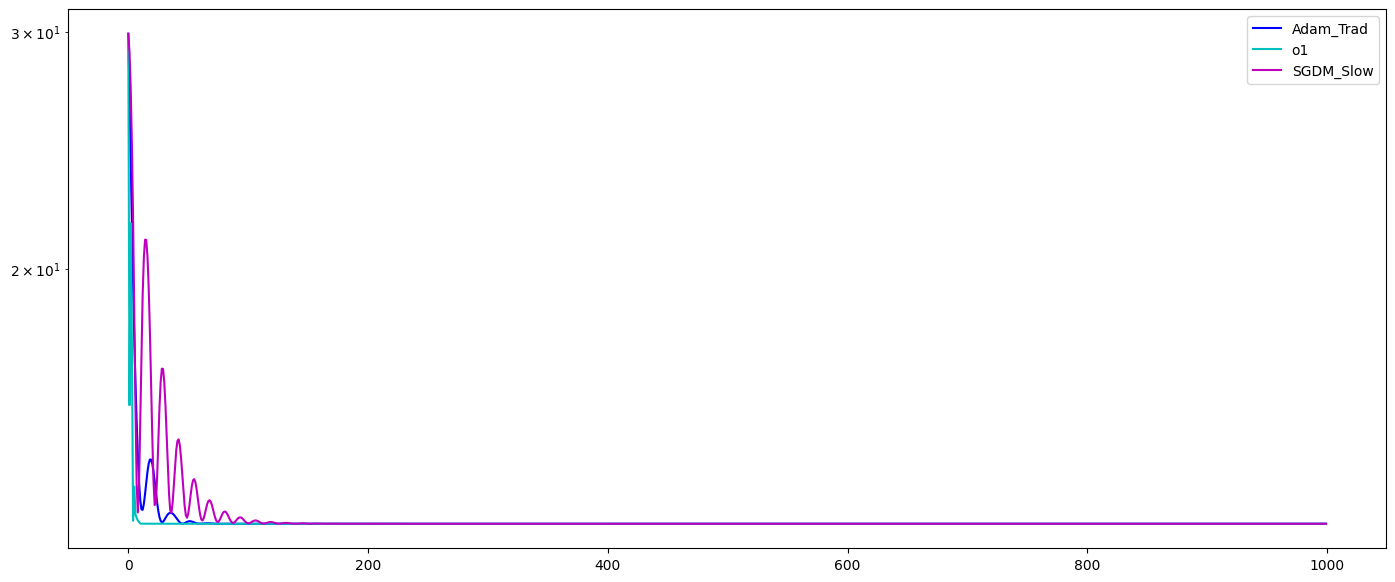

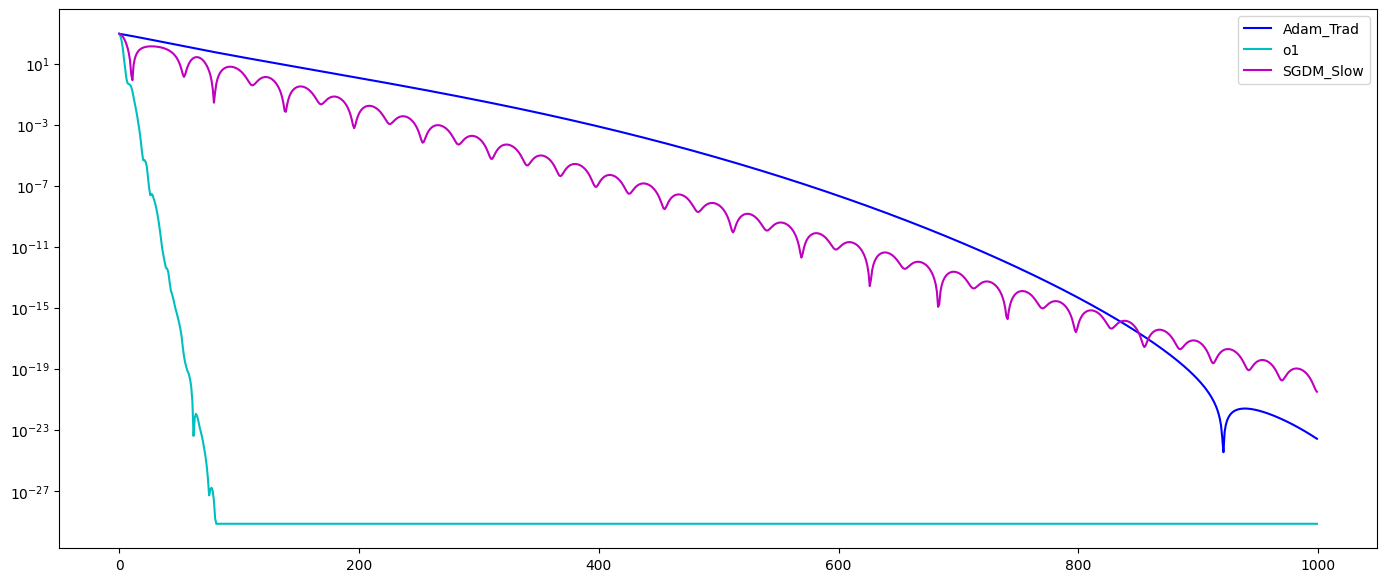

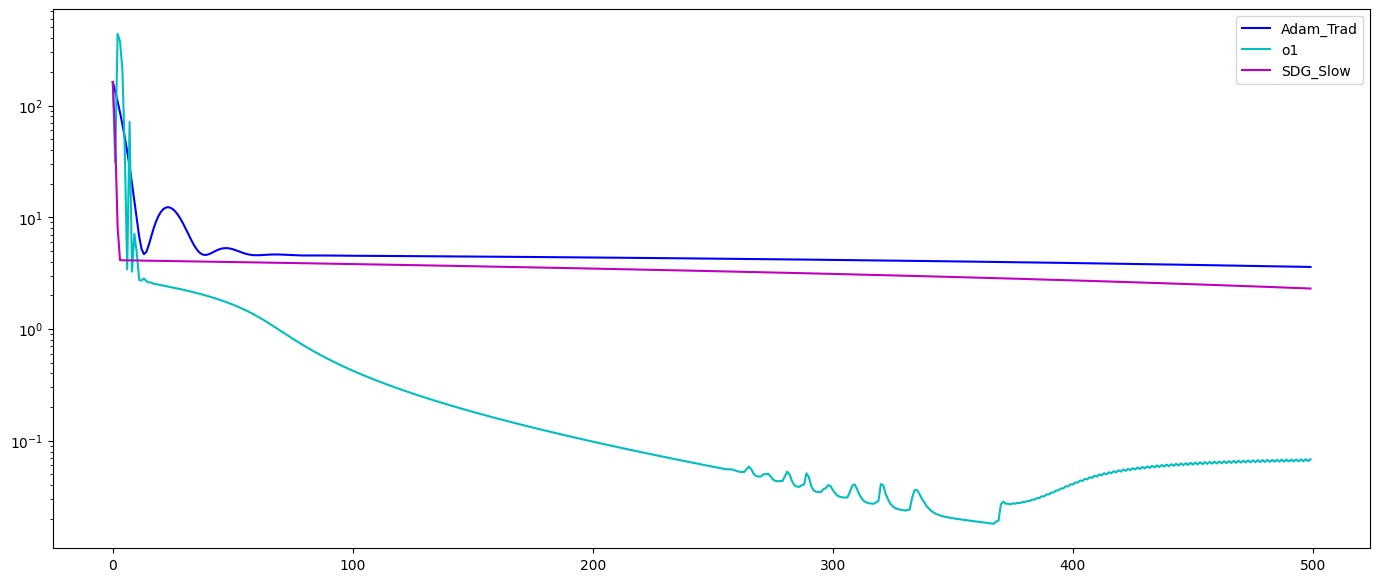

In [ ]:
#Compet des o1_3. Algos génétiques
o1NN = NeuralN([Layer_Dense(6, 4, 1), Layer_Dense(4, 3, 1), Layer_Dense(3, 1, 1)])
o1NN.load_from_file(path2, "o1_3_best")

NNinit = o1NN
class o1Agent:
    def __init__(self, NN):
        self.NN = NN.mutNN(0.3, 0.04)
        self.loss = 0
        self.state = True

    def evaluate(self, NNtest):
        if self.state:
            o1 = Algos(o1_3_a, [0.6], 4, name="o1", vlist=[0,[0,0,0,0,0], self.NN, 0])

            opt1 = Opti(o1, NNtest.mutNN(0,0), grastrigin, rastrigin)
            r = opt1.train2(50)
            self.loss += r[len(r)-1]

            opt2 = Opti(o1, NNtest.mutNN(0,0), grhimmelblau, himmelblau)
            r = opt2.train2(30)
            self.loss += r[len(r)-1]*(10**5)

            opt3 = Opti(o1, NNtest.mutNN(0,0), grosenbrock, rosenbrock)
            r = opt3.train2(150)
            self.loss += r[len(r)-1]
            if m.isnan(self.loss):
                self.state = False

    def mutate(self, bestAgent, p, cr):
        self.loss = 0
        self.state = True
        self.NN = bestAgent.NN.mutNN(p, cr)

nb_generations = 20
pop = 10
nb_iter_par_gen = 20
Agents = []
Results = []

for i in range(pop):
    Agents.append(o1Agent(NNinit))
Agents[0].NN = NNinit.mutNN(0,0)

lNNt = [NeuralN([Layer_Dense(1,1,1)]) for a in range(nb_iter_par_gen)]

for NNt in lNNt:
    NNt.attribNN_r(fact=7)

#Point de départ sensible sur rosenbrock. Je le fais passer par là pour le forcer à se confronter à des situations délicates.
lNNt[0].l[0].weights[0][0] = -1.5
lNNt[0].l[0].biases[0] = 2.5

for e in range(nb_generations):

    for iter in range(nb_iter_par_gen):
        for ag in Agents:
            ag.evaluate(lNNt[iter])

    indBest, bestLoss = 0, 10**9
    for i, ag in enumerate(Agents):
        if ag.loss < bestLoss and ag.state:
            bestLoss, indBest = ag.loss, i
    Results.append(bestLoss)
    
    for i in range(pop):
        if i != indBest:
            Agents[i].mutate(Agents[indBest], 0.3, 0.01*((bestLoss)**(1/9)))
    Agents[indBest].loss = 0
    Agents[indBest].state = True
    print('Génération '+str(e)+' done, bestloss = '+str(bestLoss))



print(Results)
#Comparaison
best = Algos(o1_3_a, [0.6], 4, name="o1", vlist=[0,[0,0,0,0,0], Agents[indBest].NN, 0])
Visu(NeuralN([Layer_Dense(1,1,1)]), grastrigin, rastrigin, [ADAM_Trad, best, SGDM_Slow], 1000, [-3.1, -2.3]).plt()
#Visu(NeuralN([Layer_Dense(1,1,1)]), grastrigin, rastrigin, [ADAM_Trad, best, SGDM_Slow], 300, [-3.3, -3.3]).visu((-5.1, 5.1), (-5.1, 5.1), 0.01, 0.2, True)
Visu(NeuralN([Layer_Dense(1,1,1)]), grhimmelblau, himmelblau, [ADAM_Trad, best, SGDM_Slow], 1000, [-5.5, 5.5]).plt()
#Visu(NeuralN([Layer_Dense(1,1,1)]), grhimmelblau, himmelblau, [ADAM_Trad, best, SGDM_Slow], 300, [-5.5, 5.5)]).visu((-5.5, 5.5), (-5,5), 0.01, 0.2, True)
#Visu(NeuralN([Layer_Dense(1,1,1)]), grosenbrock, rosenbrock,[ADAM_Trad, best, SGDM_Slow], 1000, [-1.5, 2.5]).visu((-3, 3), (-4, 7), 0.002, 0.2, True)
Visu(NeuralN([Layer_Dense(1,1,1)]), grosenbrock, rosenbrock,[ADAM_Trad, best, SGD_Slow], 500, [-1.5, 1]).plt()

In [ ]:
Agents[indBest].NN.save_to_file(path2, "o1_3_best")

Implémentation d'autres fonctions de test sur lesquelles n'a pas été entrainé o1 pour évaluer ses performances par rapport aux autres optimizers.

In [ ]:
def three_hump(lst):
    x, y = lst[0], lst[1]
    return(2*(x**2)-1.05*(x**4)+(x**6)/6 +x*y + y**2)
def gthree_hump(lst):
    x, y = lst[0], lst[1]
    return [4*x-4.2*(x**3)+x**5+y, 2*y]